As a quick follow-on to the previous notebooks, this is a demonstration of how meaningful representations of data can be used to detect outliers. This is a demonstration of the SGDOneClassSVM using the NMF topic model trained earlier. As a quick refresher, remember than a OneClassSVM is a 

In [1]:
%matplotlib inline
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.decomposition import MiniBatchNMF
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import time

BASE_PATH = '../data/nih/images/'
OUTPUT_SHAPE = (128, 128)
SEED = 101

In [2]:
def load_image(fname, output_shape=OUTPUT_SHAPE):
    """Function to load image and resize image to target output_shape. 
    Assumes grayscale input and will select first channel if multichannel image is read in."""
    img = io.imread(fname)
    if len(img.shape)>2:
        img = img[:,:,0]
    img = transform.resize(img, output_shape=output_shape)
    return img

def load_image_batch(fnames, n_jobs=4, output_shape=OUTPUT_SHAPE, verbose=False):
    """Helper function for efficiently loading images from disk."""
    if verbose:
        img_batch = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(load_image)(fname) for fname in tqdm(fnames))
    else:
        img_batch = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(load_image)(fname) for fname in fnames)
    img_batch = np.array(img_batch)
    return img_batch

In [3]:
df = pd.read_csv('../data/nih/sample_labels.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


Load the images from disk and reshape into the proper format.

In [4]:
fnames = [BASE_PATH + fname for fname in df['Image Index'].tolist()]
X = load_image_batch(fnames, n_jobs=-1, verbose=True)
X.shape

100%|█████████████████████████████████████████████████████████████████████████████| 5606/5606 [00:30<00:00, 182.87it/s]


(5606, 128, 128)

In [5]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X = normalize(X)
X.shape

(5606, 16384)

Load a pretrained NMF model (from previous run) and transform the dataset to topic space.

In [6]:
nmf = joblib.load('../output/nmf_0_128.joblib')
nmf

MiniBatchNMF(init='nndsvda', max_iter=10, max_no_improvement=20,
             n_components=20, random_state=101, verbose=True)

In [7]:
X_nmf = nmf.transform(X)
X_nmf.shape

(5606, 20)

The SGDOneClassSVM is actually a linear model, so we'll need to add a kernel approximation technique (Nystroem) into the pipeline. Otherwise, model performance will suffer due to a lack of interactions between features. The OneClassSVM is actually pretty sensitive to the choice of gamma and nu, and is apparently not super-performant when it comes to outlier detection. Nevertheless, using the default gamma value from the [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) `1 / (n_features * X.var())` works rather well and is a good starting point.

In [8]:
gamma = 1 / (X_nmf.shape[1]*X_nmf.var())
gamma

248.95434324953666

In [9]:
transform = Nystroem(
    kernel='rbf',
    n_components=100,
    gamma=gamma
)

clf = SGDOneClassSVM(
    nu=0.01, # This is essentially an estimate of the fraction of outliers
    learning_rate='optimal',
    max_iter=1000,
    random_state=SEED
)

pipe = Pipeline(
    [
        ('transform',transform),
        ('clf',clf)
    ]
)

In [10]:
start = time.time()
y_pred = pipe.fit_predict(X_nmf)
end = time.time()
print('Time to train a OneClassSVM: %0.2fs' % (end-start))

Time to train a OneClassSVM: 0.03s


In [11]:
pd.value_counts(y_pred)

 1    5505
-1     101
dtype: int64

As we can see, the model trains incredibly fast and returns a -1 or a 1, corresponding to outlier and inlier, respectively. The method for decision_function can be used to rank the strength of inliers/outliers for potential human intervention.

In [12]:
df['distance'] = pipe.decision_function(X_nmf)
df['y_pred'] = y_pred
df.sort_values('distance', ascending=True).head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,distance,y_pred
5203,00027765_000.png,Infiltration,0,27765,002Y,M,AP,2544,3056,0.139,0.139,-0.101088,-1
4059,00020008_001.png,No Finding,1,20008,005Y,M,AP,2544,3056,0.139,0.139,-0.099013,-1
1503,00007830_002.png,Pneumothorax,2,7830,010Y,M,AP,2048,2500,0.168,0.168,-0.097393,-1
2112,00010843_000.png,No Finding,0,10843,003Y,F,AP,2048,2500,0.168,0.168,-0.095696,-1
1432,00007438_000.png,No Finding,0,7438,005Y,F,AP,2048,2500,0.168,0.168,-0.095576,-1


Finally, let's inspect some of the outliers and inliers, just to see what types of examples we have.

In [13]:
X_bad = X[y_pred == -1]
X_good = X[y_pred == 1]

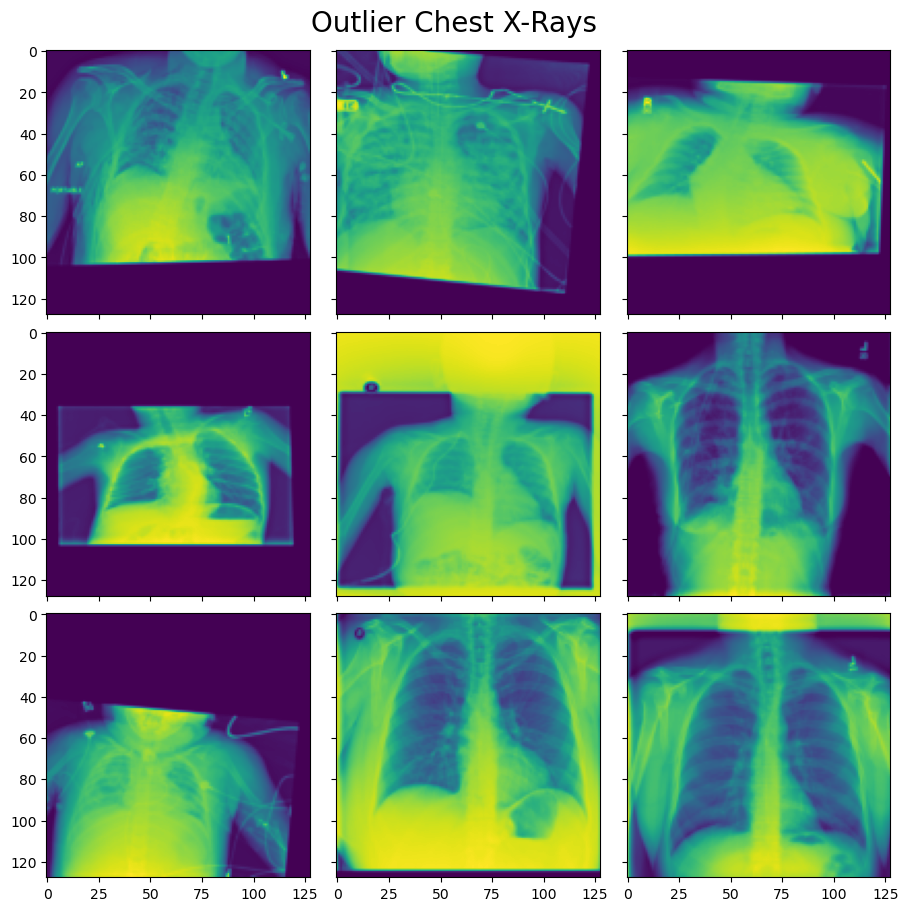

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)
for i in range(9):
    ax.flat[i].imshow(X_bad[i].reshape(OUTPUT_SHAPE))
fig.suptitle('Outlier Chest X-Rays', fontsize=20)
plt.show()

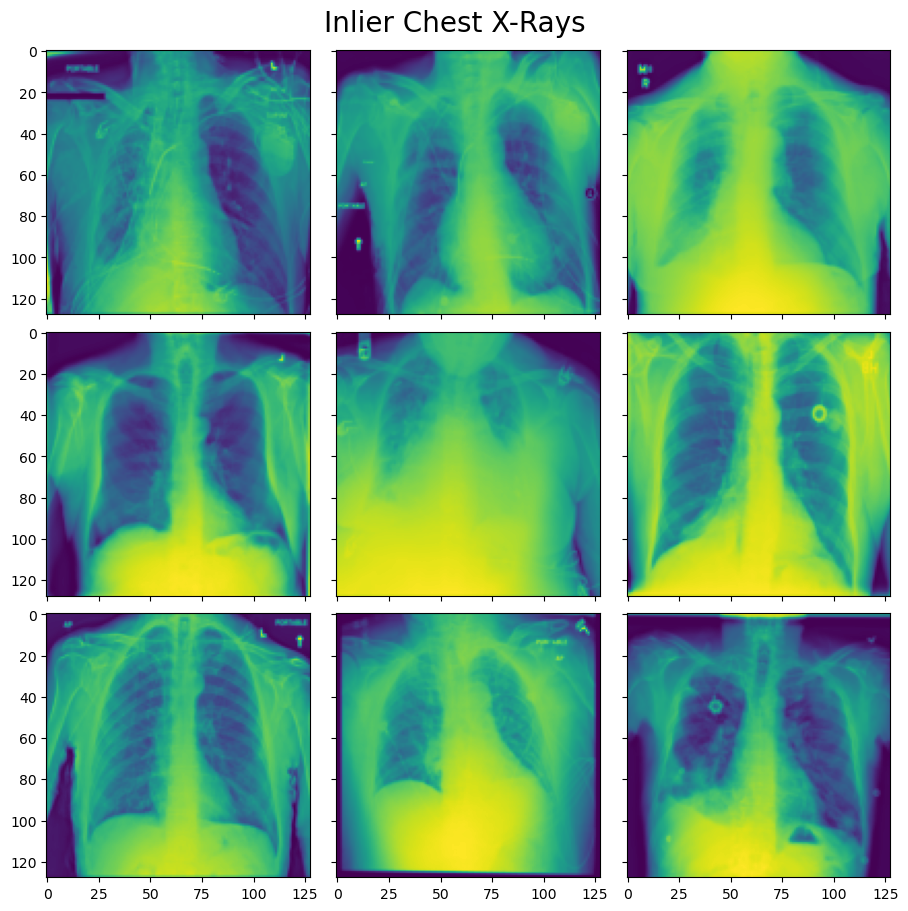

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)
for i in range(9):
    ax.flat[i].imshow(X_good[i].reshape(OUTPUT_SHAPE))
fig.suptitle('Inlier Chest X-Rays', fontsize=20)
plt.show()